In [2]:
%load_ext autoreload
%autoreload 2

In [17]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pathlib


import common.loss_utils as loss_utils
import common.utils as utils

import sys
sys.path.append('./experiments/dgmr-oneshot')
import dgmr


In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [6]:
FORECAST = 24
INPUT_STEPS = 4
BATCH_SIZE = 16

In [7]:
p = pathlib.Path('data/test.npz')
f = np.load(p)
times = f['times']
data = f['data']

In [8]:
times.shape, data.shape

((2189,), (2189, 325, 400))

In [9]:
_MEAN_PIXEL = 240.3414
_STD_PIXEL = 146.52366

torch.manual_seed(7)
tsfm = transforms.Compose([
    transforms.Normalize(_MEAN_PIXEL, _STD_PIXEL),
])

In [10]:
def check_times(tstart, tend):
    return int((tend - tstart) / np.timedelta64(1, 'm')) == 175

class CustomTensorDataset(torch.utils.data.Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, times, data, tsfm, shuffle=True, random_state=7):
        self.times = times
        self.data = data
        self.generator = np.random.RandomState(random_state)
        self.indices = np.arange(len(self.times) - 35)
        self.tsfm = tsfm
        if shuffle:
            self.generator.shuffle(self.indices)
        self.index_to_randx = [self.generator.randint(0, data.shape[2] - 128) for _ in range(len(self.indices))]
        self.index_to_randy = [self.generator.randint(0, data.shape[1] - 128) for _ in range(len(self.indices))]

    def _get_crop(self, index, data):
        # roughly over the mainland UK
        # going determinstic for repeatable experiments
        rand_x = self.index_to_randx[index] # self.generator.randint(0, input_slice.shape[2] - 128)
        rand_y = self.index_to_randy[index] # self.generator.randint(0, input_slice.shape[1] - 128)
        
        # make a data selection
        return data[:, rand_y : rand_y + 128, rand_x : rand_x + 128]

    def __getitem__(self, i):
        index = self.indices[i]
        tend = self.times[index + 35]
        tstart = self.times[index]
        if not check_times(tstart, tend):
            return self.__getitem__((i + 35) % len(self))
        all_data = self.data[index:index+INPUT_STEPS+24]
        all_data = self._get_crop(index, all_data)
        all_data = torch.FloatTensor(all_data)
        all_data = self.tsfm(all_data)
        x = all_data[:INPUT_STEPS]
        y = all_data[INPUT_STEPS:]
        return x, y

    def __len__(self):
        return len(self.times) - 35

ds = CustomTensorDataset(times, data, tsfm)
dl = torch.utils.data.DataLoader(
    ds,
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_workers=4,
    prefetch_factor=4
)


In [11]:
x, y = ds[0]

In [12]:
x.shape, y.shape

(torch.Size([4, 128, 128]), torch.Size([24, 128, 128]))

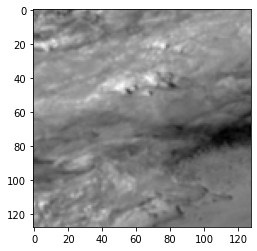

In [13]:
plt.imshow(x[-1], cmap='gray')

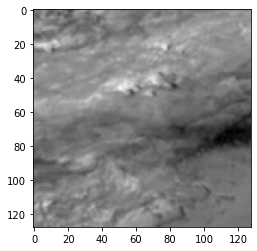

In [14]:
plt.imshow(y[0], cmap='gray')

In [15]:
ccs = dgmr.common.ContextConditioningStack(
    input_channels=1,
    conv_type='standard',
    output_channels=160,
)

sampler = dgmr.generators.Sampler(
    forecast_steps=FORECAST,
    latent_channels=96,
    context_channels=160,
    output_channels=1,
)

model = dgmr.generators.Generator(ccs, sampler)
model.load_state_dict(torch.load('weights/dgmr_oneshot/dgmr_epochs=100_loss=0.183.pt'))
model = model.to(DEVICE)


In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model)} trainable parameters')

The model has 235695682 trainable parameters


In [18]:
model.train()
criterion = loss_utils.MS_SSIM(
    data_range=1023.0, size_average=True, win_size=3, channel=24)
final_layer = torch.nn.AvgPool2d(kernel_size=2)

scores = []
running_total = 0
running_count = 0
pbar = tqdm.tqdm(dl)

LOOKS = 63
all_preds = []
for i, (srcs, trgs) in enumerate(pbar):
    x = srcs.to(DEVICE)
    y = trgs.to(DEVICE)
    if i > LOOKS:
        break
    # add a dimension because 1D image
    x = torch.unsqueeze(x, dim=2)
    y = torch.unsqueeze(y, dim=2)
    
    with torch.no_grad():
        preds = model(x)
    
    y = y * _STD_PIXEL + _MEAN_PIXEL
    preds = preds * _STD_PIXEL + _MEAN_PIXEL
#     preds[preds > 1023] = 1023
#     preds[preds < 0] = 0
#     preds = np.squeeze(preds.detach().cpu().numpy()).reshape(16*24, 128, 128)
#     preds = cv2.blur(preds, (2,2))
#     preds = preds.reshape(16, 24, 128, 128)
#     preds = np.expand_dims(preds, axis=2)
#     preds = torch.FloatTensor(preds).to(DEVICE)
    all_preds.append(np.squeeze(preds.detach().cpu().numpy()))

    score = utils.get_msssim(preds[:,:,:,32:96,32:96], y[:,:,:,32:96,32:96], average=False)
    score = score.detach().cpu().numpy()
    scores.append(score)
    
    running_total += np.mean(score)
    running_count += 1
    
    pbar.set_description(f'Avg Score: {running_total/running_count}')

    

  0%|          | 0/135 [00:00<?, ?it/s]


AttributeError: module 'common.utils' has no attribute 'get_mssim'

In [20]:
preds = preds.squeeze(dim=2)
y = y.squeeze(dim=2)

In [21]:
preds.shape

torch.Size([16, 24, 128, 128])

In [22]:
utils.get_msssim(preds, y, average=True)

tensor(0.8466, device='cuda:0')

In [23]:
ret = utils.get_msssim(preds, y, average=False)

In [26]:
ret.mean(axis=0)

tensor([0.9661, 0.9349, 0.9086, 0.8864, 0.8670, 0.8524, 0.8437, 0.8388, 0.8313,
        0.8270, 0.8253, 0.8249, 0.8247, 0.8288, 0.8288, 0.8317, 0.8340, 0.8350,
        0.8335, 0.8296, 0.8240, 0.8214, 0.8161, 0.8048], device='cuda:0')

In [32]:
preds.shape, y.shape

(torch.Size([16, 24, 128, 128]), torch.Size([16, 24, 128, 128]))

In [35]:
a = preds.unsqueeze(dim=2)[:,:,:,32:96,32:96]
b = y.unsqueeze(dim=2)[:,:,:,32:96,32:96]

In [36]:
a.shape, b.shape

(torch.Size([16, 24, 1, 64, 64]), torch.Size([16, 24, 1, 64, 64]))

In [37]:
r = get_mssim(a, b, average=False)

In [17]:
all_preds = np.concatenate(all_preds, axis=0)
scores = np.concatenate(scores, axis=0)

In [18]:
all_preds.shape, scores.shape

((1024, 24, 128, 128), (1024, 24))

In [19]:
x, y = ds[2]

In [20]:
x.shape, y.shape

(torch.Size([4, 128, 128]), torch.Size([24, 128, 128]))

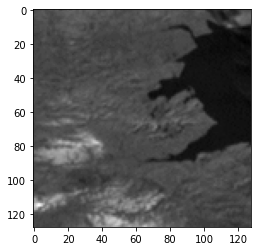

In [21]:
plt.imshow(x[-1], cmap='gray')

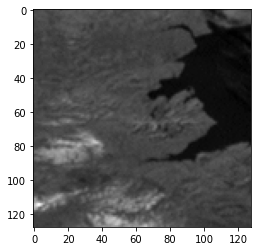

In [22]:
plt.imshow(y[0], cmap='gray')

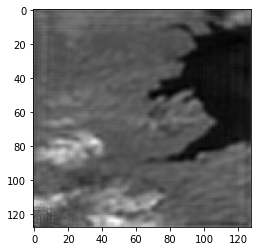

In [23]:
plt.imshow(all_preds[2,0], cmap='gray')

In [24]:
s = scores.mean(axis=1)

In [25]:
worst = np.argsort(s)

In [29]:
import cv2
x = torch.tensor([])

In [186]:
plt.rc('animation', html='jshtml')
from matplotlib import animation

def get_mssim(y, x):
    if len(y.shape) == 2:
        # we need to specify a number of channels. This sets it to 1 and calls the function again
        return get_mssim(np.expand_dims(y, 0), np.expand_dims(x, 0))
    if len(y.shape) == 4:
        y = y.reshape(-1, y.shape[2], y.shape[3])
        x = x.reshape(-1, x.shape[2], x.shape[3])
    assert len(y.shape) == 3
    mssim_loss = loss_utils.MS_SSIMLoss(data_range=1023, channels=y.shape[0])
    yd = np.expand_dims(y, 0) # /255 * (MAX - MIN) + MIN
    xd = np.expand_dims(x, 0) # /255 * (MAX - MIN) + MIN
    return 1.0 - mssim_loss(
        torch.Tensor(yd),
        torch.Tensor(xd),
    ).item()

def warp_flow(img, flow):
    h, w = flow.shape[:2]
    flow = -flow
    flow[:, :, 0] += np.arange(w)
    flow[:, :, 1] += np.arange(h)[:, np.newaxis]
    res = cv2.remap(img, flow, None, cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    return res

def plot_animation(input_images, images, dgmr_images):
    fig, (ax_true, ax_dgmr) = plt.subplots(1, 2, figsize=(20,20))
    plt.close() # Prevents extra axes being plotted below animation

    img_true = ax_true.imshow(images[0], cmap='gray')
    img_dgmr = ax_dgmr.imshow(dgmr_images[0], cmap='gray')

    def animate(i):
        nonlocal images, dgmr_images
        ref = images[i, 32:96, 32:96]
        #print(dgmr_images[i])
        #dgmr_img = cv2.fastNlMeansDenoising(dgmr_images[i].astype(np.uint16), h = [2], normType = cv2.NORM_L1).astype(np.int16)
        #dgmr_img = dgmr_images[i].astype(np.short)
        dgmr_img = torch.tensor(dgmr_images[i])
        #print(dgmr_img.shape)
        dgmr_img = arcnn(dgmr_img.reshape(1, 1, 128, 128).cuda()).detach().cpu().numpy()[0][0]
        #dgmr_img  = dgmr_images[i]
        #print(dgmr_img)
        
        pers_score = get_mssim(input_images[-1, 32:96,32:96], ref)
        dgmr_score = get_mssim(dgmr_img[32:96,32:96], ref)
        ax_true.title.set_text(f'Step {i} Persistence MS-SSIM: {pers_score}')
        ax_dgmr.title.set_text(f'Step {i} DGMR MS-SSIM: {dgmr_score}')
        return img_true.set_data(images[i]), img_dgmr.set_data(dgmr_img)

    return animation.FuncAnimation(fig, animate, frames=images.shape[0], interval=1000, blit=False)


In [187]:
idx = worst[-1] 
x, y = ds[idx]
x = x * _STD_PIXEL + _MEAN_PIXEL
y = y * _STD_PIXEL + _MEAN_PIXEL
plot_animation(x, y, all_preds[idx])


In [87]:
ds[worst[1]]


(tensor([[[-0.5551, -0.5483, -0.5483,  ...,  0.2024,  0.6870,  1.0623],
          [-0.5278, -0.5347, -0.5483,  ..., -0.2480, -0.0842,  0.4208],
          [-0.5756, -0.6302, -0.6507,  ..., -0.1730, -0.2071, -0.1320],
          ...,
          [-0.8691, -0.8281, -0.8008,  ...,  0.5232,  0.2775,  0.0250],
          [-0.7394, -0.6370, -0.5961,  ..., -0.0501, -0.0911, -0.1730],
          [-0.5483, -0.4459, -0.3845,  ..., -0.1661, -0.0092, -0.0228]],
 
         [[-0.5210, -0.5347, -0.5551,  ...,  0.7075, -0.1047, -0.2958],
          [-0.4801, -0.5005, -0.5483,  ...,  0.7075, -0.1320, -0.3436],
          [-0.5551, -0.5961, -0.6302,  ...,  0.2775, -0.1457,  0.0454],
          ...,
          [-0.8486, -0.8623, -0.8691,  ..., -0.1866,  0.0591,  0.3594],
          [-0.8008, -0.8213, -0.8008,  ..., -0.1934,  0.1273,  0.1478],
          [-0.6985, -0.7326, -0.7121,  ..., -0.1866,  0.1478,  0.2229]],
 
         [[-0.5005, -0.5278, -0.5005,  ...,  0.4140,  0.2229,  0.1000],
          [-0.4869, -0.5005,

In [106]:
import scipy.io

In [178]:
weights = scipy.io.loadmat("q20.mat")

class ARCNN(nn.Module):
    def __init__(self, weight):
        super().__init__()

        # PyTorch's Conv2D uses zero-padding while the matlab code uses replicate
        # So we need to use separate padding modules
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=7)
        self.conv22 = nn.Conv2d(32, 16, kernel_size=1)
        self.conv3 = nn.Conv2d(16, 1, kernel_size=5)

        self.pad2 = nn.ReplicationPad2d(2)
        self.pad3 = nn.ReplicationPad2d(3)
        self.pad4 = nn.ReplicationPad2d(4)

        self.relu = nn.ReLU(inplace=True)

        # Load the weights from the weight dict
        self.conv1.weight.data = torch.from_numpy(
            weight['weights_conv1']
            .transpose(2, 0, 1)
            .reshape(64, 1, 9, 9)
            .transpose(0, 1, 3, 2)
        ).float()
        self.conv1.bias.data = torch.from_numpy(
            weight['biases_conv1']
            .reshape(64)
        ).float()

        self.conv2.weight.data = torch.from_numpy(
            weight['weights_conv2']
            .transpose(2, 0, 1)
            .reshape(32, 64, 7, 7)
            .transpose(0, 1, 3, 2)
        ).float()
        self.conv2.bias.data = torch.from_numpy(
            weight['biases_conv2']
            .reshape(32)
        ).float()

        self.conv22.weight.data = torch.from_numpy(
            weight['weights_conv22']
            .transpose(2, 0, 1)
            .reshape(16, 32, 1, 1)
            .transpose(0, 1, 3, 2)
        ).float()
        self.conv22.bias.data = torch.from_numpy(
            weight['biases_conv22']
            .reshape(16)
        ).float()

        self.conv3.weight.data = torch.from_numpy(
            weight['weights_conv3']
            .reshape(1, 16, 5, 5)
            .transpose(0, 1, 3, 2)
        ).float()
        self.conv3.bias.data = torch.from_numpy(
            weight['biases_conv3']
            .reshape(1)
        ).float()

    def forward(self, x):
        x = self.pad4(x)
        x = self.relu(self.conv1(x))

        x = self.pad3(x)
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv22(x))

        x = self.pad2(x)
        x = self.conv3(x)

        return x

In [179]:
arcnn = ARCNN(weights).cuda().eval()

In [120]:
from torchinfo import summary
summary(arcnn, input_size = (1, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
ARCNN                                    --                        --
├─ReplicationPad2d: 1-1                  [1, 1, 136, 136]          --
├─Conv2d: 1-2                            [1, 64, 128, 128]         5,248
├─ReLU: 1-3                              [1, 64, 128, 128]         --
├─ReplicationPad2d: 1-4                  [1, 64, 134, 134]         --
├─Conv2d: 1-5                            [1, 32, 128, 128]         100,384
├─ReLU: 1-6                              [1, 32, 128, 128]         --
├─Conv2d: 1-7                            [1, 16, 128, 128]         528
├─ReLU: 1-8                              [1, 16, 128, 128]         --
├─ReplicationPad2d: 1-9                  [1, 16, 132, 132]         --
├─Conv2d: 1-10                           [1, 1, 128, 128]          401
Total params: 106,561
Trainable params: 106,561
Non-trainable params: 0
Total mult-adds (G): 1.75
Input size (MB): 0.07
Forward/backward pass siz

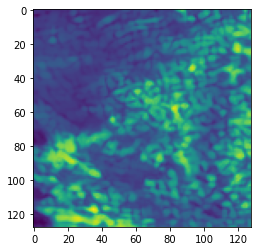

In [162]:
x = x.cuda()
arcnn(x[-1].reshape(1, 1, 128, 128))
plt.imshow(arcnn(x.reshape(1, 1, 128, 128)).detach().cpu().numpy()[0][0])

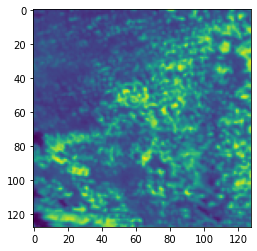

In [157]:
plt.imshow(x[-1].reshape(1, 1, 128, 128).detach().cpu().numpy()[0][0])